In [3]:
library(tidyverse)
library(repr)
library(tidymodels)

In [4]:
Stars <- read_csv("data/Stars.csv")

Parsed with column specification:
cols(
  Temperature = col_double(),
  L = col_double(),
  R = col_double(),
  A_M = col_double(),
  Color = col_character(),
  Spectral_Class = col_character(),
  Type = col_double()
)



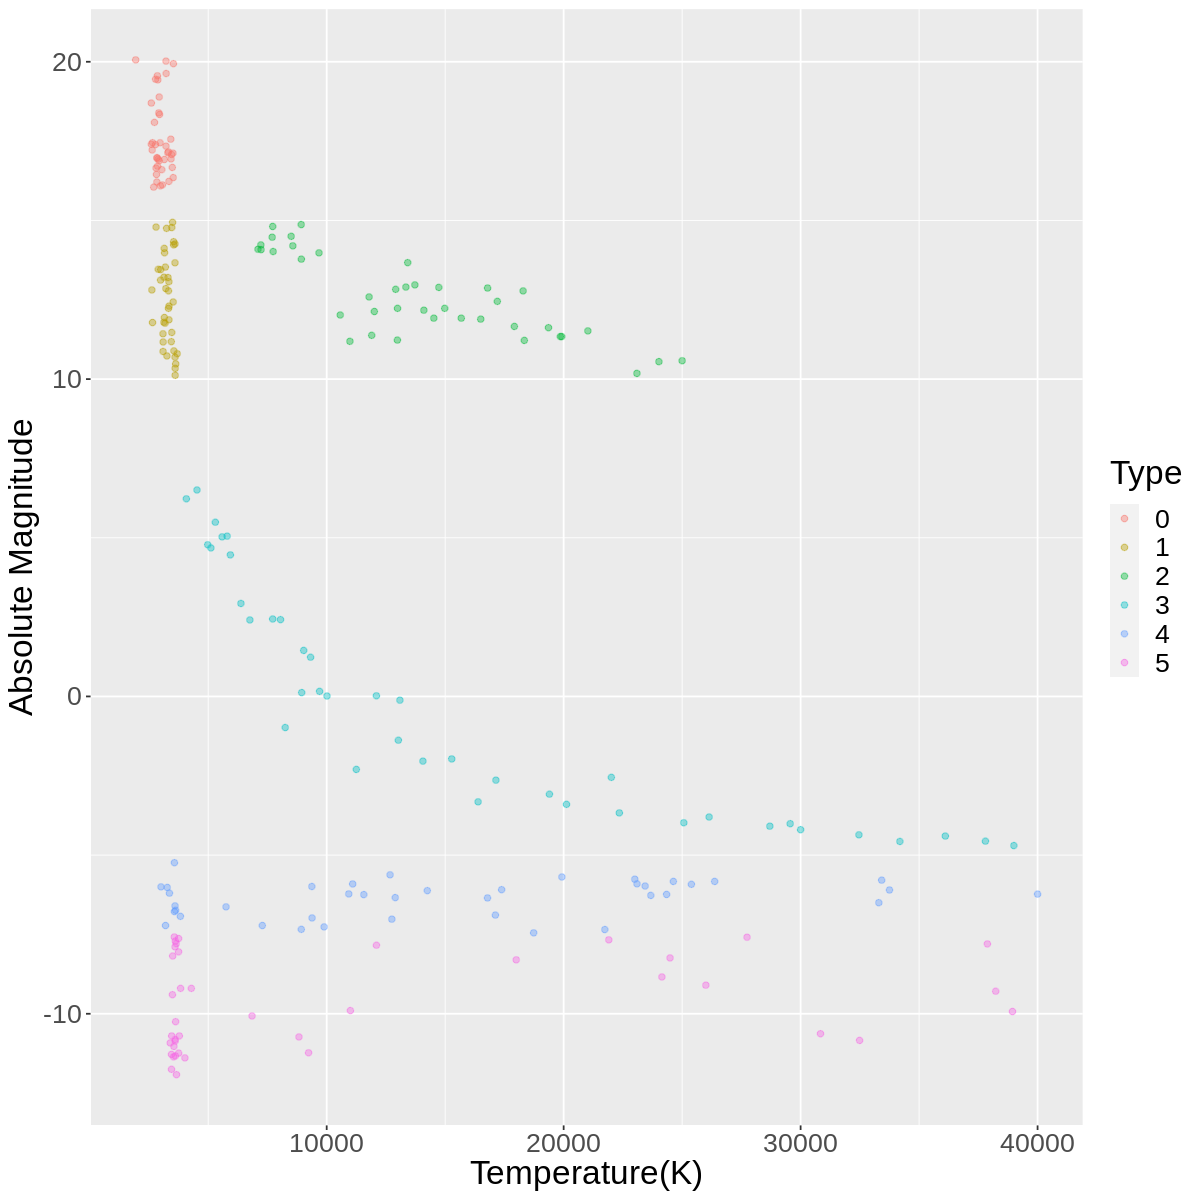

In [5]:
stars <- Stars %>%
select(Temperature, A_M, Type) %>%
mutate(Type = as_factor(Type))

options(repr.plot.width = 10, repr.plot.height = 10)

plot <- stars %>%
ggplot(aes(x = Temperature, y = A_M, color = Type)) +
geom_point(alpha = 0.4) +
xlab("Temperature(K)") +
ylab("Absolute Magnitude")+
theme(text = element_text(size = 20)) 

plot

In [6]:
star_split <- initial_split(stars, prop = 0.75, strata = Type)
star_training <- training(star_split)
star_testing <- testing(star_split)

star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

star_recipe <- recipe(Type ~ Temperature + A_M, data = star_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

star_vfold <- vfold_cv(star_training, v = 5, strata = Type)

gridvals <- tibble(neighbors = seq(from = 1, to = 100))

In [7]:
star_results <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_spec) %>%
tune_grid(resamples = star_vfold, grid = gridvals) %>%
collect_metrics()

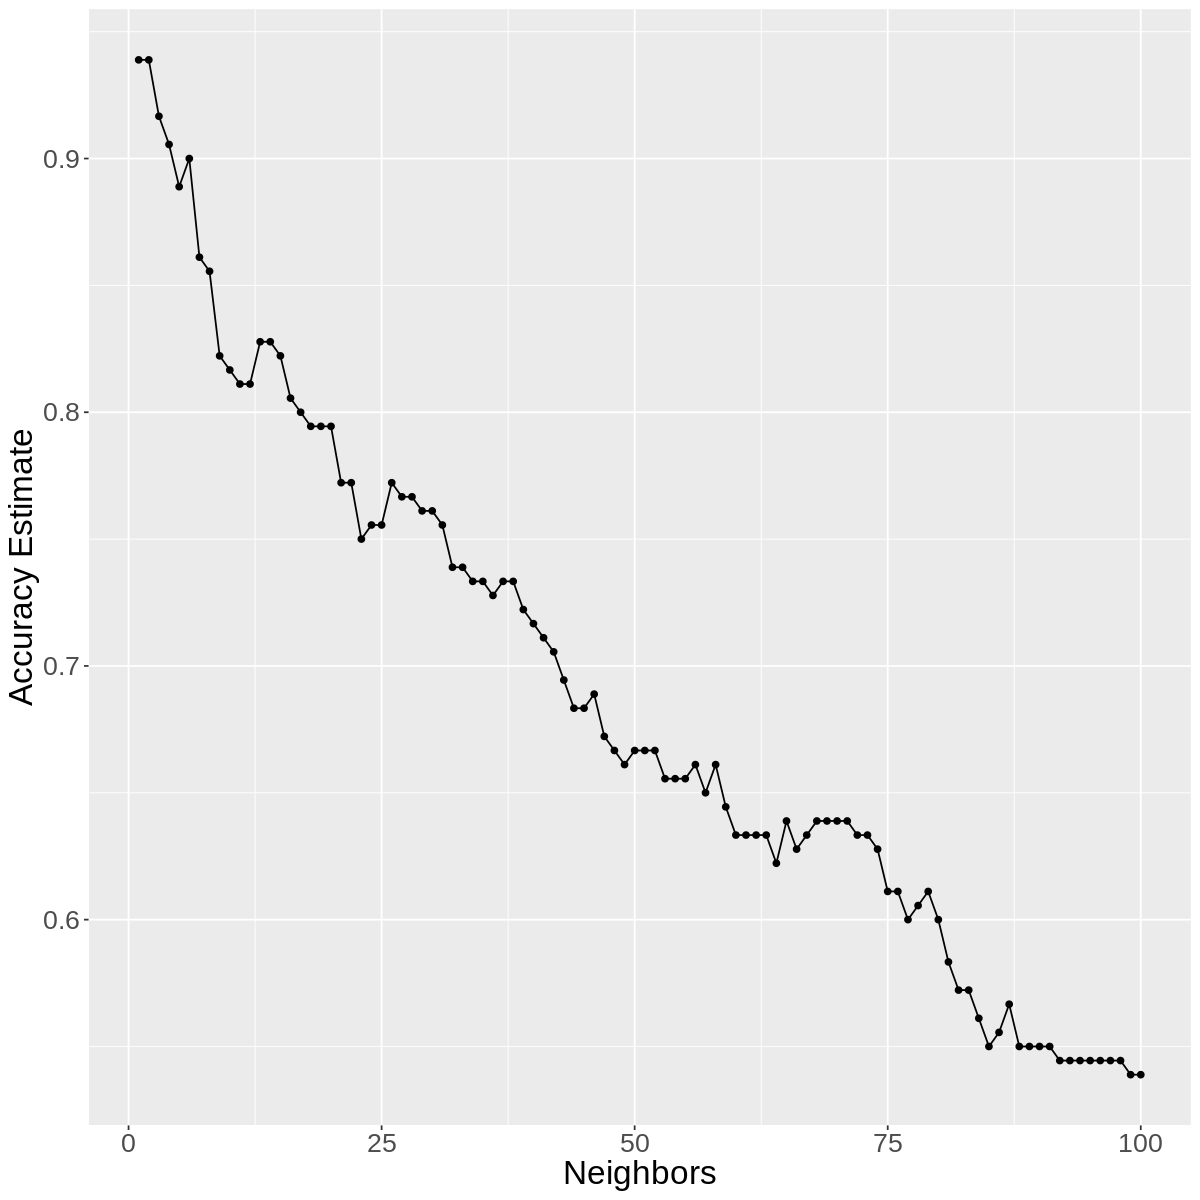

In [11]:
accuracies <- star_results %>%
filter(.metric == "accuracy")

acc_plot <- accuracies %>% 
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
theme(text = element_text(size = 20))

acc_plot

In [29]:
star_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
set_engine("kknn") %>%
set_mode("classification")

star_fit <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_best_spec) %>%
fit(data = star_training)

star_predictions <- predict(star_fit, star_testing) %>%
bind_cols(star_testing)

star_test_predictions <- star_predictions %>%
metrics(truth = Type, estimate = .pred_class) %>%
filter(.metric == "accuracy")

confusion <- star_predictions %>%
conf_mat(truth = Type, estimate = .pred_class)

star_test_predictions
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9666667


          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0 10  0  0
         4  0  0  0  0  9  1
         5  0  0  0  0  1  9